In [1]:
import os, random, joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

In [2]:

# ---------------- CONFIG ----------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

DATA_CSV = "synthetic_data.csv"
IMAGE_DIR = "synthetic_images"
os.makedirs(IMAGE_DIR, exist_ok=True)
BATCH_SIZE = 16
NUM_EPOCHS = 20
LR = 5e-5
WEIGHT_DECAY = 1e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 224
MODEL_SAVE_PATH = "multimodal_model.pth"
SCALER_SAVE_PATH = "tabular_scaler.joblib"


In [3]:
# ---------------- DATA GENERATION ----------------
def generate_synthetic_data(num_samples=600):
    data = []
    for i in range(num_samples):
        bedrooms = random.randint(1, 5)
        bathrooms = random.randint(1, 4)
        sqft = random.randint(800, 4000)
        neighborhood = random.choice(["A", "B", "C"])

        img = Image.new("RGB", (256, 256), color=(random.randint(0,255), random.randint(0,255), random.randint(0,255)))
        draw = ImageDraw.Draw(img)
        draw.rectangle([50, 50, 200, 200], fill=(random.randint(0,255), random.randint(0,255), random.randint(0,255)))
        img_path = os.path.join(IMAGE_DIR, f"house_{i}.jpg")
        img.save(img_path)

        base_price = 50000 + bedrooms*20000 + bathrooms*15000 + sqft*50
        neighborhood_bonus = {"A": 10000, "B": 5000, "C": 0}[neighborhood]
        noise = random.uniform(-10000, 10000)
        price = base_price + neighborhood_bonus + noise

        data.append({
            "image_path": img_path,
            "bedrooms": bedrooms,
            "bathrooms": bathrooms,
            "sqft": sqft,
            "neighborhood": neighborhood,
            "price": price
        })
    return pd.DataFrame(data)

df = generate_synthetic_data(600)
df.to_csv(DATA_CSV, index=False)
print("✅ Synthetic dataset created:", DATA_CSV)
print(df.head())


✅ Synthetic dataset created: synthetic_data.csv
                     image_path  bedrooms  bathrooms  sqft neighborhood  \
0  synthetic_images/house_0.jpg         1          1  3837            B   
1  synthetic_images/house_1.jpg         1          2  1752            C   
2  synthetic_images/house_2.jpg         1          2  3659            B   
3  synthetic_images/house_3.jpg         1          3  2208            C   
4  synthetic_images/house_4.jpg         5          3  3164            A   

           price  
0  272485.653590  
1  193788.609134  
2  279804.916868  
3  226440.812625  
4  370529.673335  


In [4]:
# ---------------- PREPROCESSING ----------------
# Scale target price
price_scaler = StandardScaler()
df['price_scaled'] = price_scaler.fit_transform(df[['price']])

# One-hot encode categorical feature
df = pd.get_dummies(df, columns=['neighborhood'], drop_first=True)

# Split data
train_df, test_df = train_test_split(df, test_size=0.15, random_state=seed)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=seed)

tabular_cols = [c for c in df.columns if c not in ['image_path', 'price', 'price_scaled']]
target_col = 'price_scaled'

# Scale tabular inputs
scaler = StandardScaler()
scaler.fit(train_df[tabular_cols])
joblib.dump(scaler, SCALER_SAVE_PATH)


['tabular_scaler.joblib']

In [5]:
# ---------------- DATASET ----------------
class HousingDataset(Dataset):
    def __init__(self, df, tabular_cols, target_col, transforms, scaler):
        self.df = df.reset_index(drop=True)
        self.tabular_cols = tabular_cols
        self.target_col = target_col
        self.transforms = transforms
        self.scaler = scaler

        self.tab_values = self.scaler.transform(self.df[self.tabular_cols])
        self.targets = self.df[self.target_col].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        if self.transforms:
            img = self.transforms(img)
        tab = self.tab_values[idx].astype(np.float32)
        target = self.targets[idx]
        return img, torch.from_numpy(tab), torch.from_numpy(target)


In [12]:
# ---------------- TRANSFORMS ----------------
train_transforms = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transforms = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataloaders
train_ds = HousingDataset(train_df, tabular_cols, target_col, train_transforms, scaler)
val_ds = HousingDataset(val_df, tabular_cols, target_col, val_transforms, scaler)
test_ds = HousingDataset(test_df, tabular_cols, target_col, val_transforms, scaler)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


In [13]:
# ---------------- MODEL ----------------
class MultimodalRegressor(nn.Module):
    def __init__(self, tabular_input_dim):
        super().__init__()
        # Pretrained CNN Backbone
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(base.children())[:-1])  # Remove last FC
        cnn_out_dim = base.fc.in_features

        # Tabular network with Dropout
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Fusion network with Dropout
        self.fusion = nn.Sequential(
            nn.Linear(cnn_out_dim + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    def forward(self, img, tab):
        x_img = self.cnn(img).view(img.size(0), -1)
        x_tab = self.tabular_net(tab)
        x = torch.cat([x_img, x_tab], dim=1)
        return self.fusion(x)


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # 🔹 weight decay added
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [17]:
best_val_loss = float('inf')
patience = 3
trigger_times = 0

# Initialize the model
model = MultimodalRegressor(tabular_input_dim=len(tabular_cols)).to(DEVICE)

# ---------------- TRAINING ----------------
train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for imgs, tabs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        imgs, tabs, targets = imgs.to(DEVICE), tabs.to(DEVICE), targets.to(DEVICE)
        preds = model(imgs, tabs)
        loss = criterion(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, tabs, targets in val_loader:
            imgs, tabs, targets = imgs.to(DEVICE), tabs.to(DEVICE), targets.to(DEVICE)
            preds = model(imgs, tabs)
            val_loss += criterion(preds, targets).item() * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # ---- Early Stopping logic ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")  # save best model
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("⛔ Early stopping triggered!")
            break

    # Step LR scheduler
    scheduler.step(val_loss)


torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("✅ Model saved!")

Epoch 1/20: 100%|██████████| 28/28 [00:02<00:00, 10.53it/s]


Epoch 1: Train Loss = 1.0432, Val Loss = 2.9864


Epoch 2/20: 100%|██████████| 28/28 [00:02<00:00, 11.82it/s]


Epoch 2: Train Loss = 0.2669, Val Loss = 0.5173


Epoch 3/20: 100%|██████████| 28/28 [00:02<00:00, 11.74it/s]


Epoch 3: Train Loss = 0.0441, Val Loss = 0.0243


Epoch 4/20: 100%|██████████| 28/28 [00:02<00:00, 11.96it/s]


Epoch 4: Train Loss = 0.0256, Val Loss = 0.0216


Epoch 5/20: 100%|██████████| 28/28 [00:02<00:00, 10.53it/s]


Epoch 5: Train Loss = 0.0191, Val Loss = 0.0165


Epoch 6/20: 100%|██████████| 28/28 [00:02<00:00, 11.92it/s]


Epoch 6: Train Loss = 0.0160, Val Loss = 0.0227


Epoch 7/20: 100%|██████████| 28/28 [00:02<00:00, 11.89it/s]


Epoch 7: Train Loss = 0.0147, Val Loss = 0.0177


Epoch 8/20: 100%|██████████| 28/28 [00:02<00:00, 11.92it/s]


Epoch 8: Train Loss = 0.0184, Val Loss = 0.0139


Epoch 9/20: 100%|██████████| 28/28 [00:02<00:00, 10.47it/s]


Epoch 9: Train Loss = 0.0135, Val Loss = 0.0144


Epoch 10/20: 100%|██████████| 28/28 [00:02<00:00, 11.94it/s]


Epoch 10: Train Loss = 0.0116, Val Loss = 0.0185


Epoch 11/20: 100%|██████████| 28/28 [00:02<00:00, 11.91it/s]


Epoch 11: Train Loss = 0.0157, Val Loss = 0.0157
⛔ Early stopping triggered!
✅ Model saved!


✅ Final Test MAE: 6206.81, RMSE: 7253.19


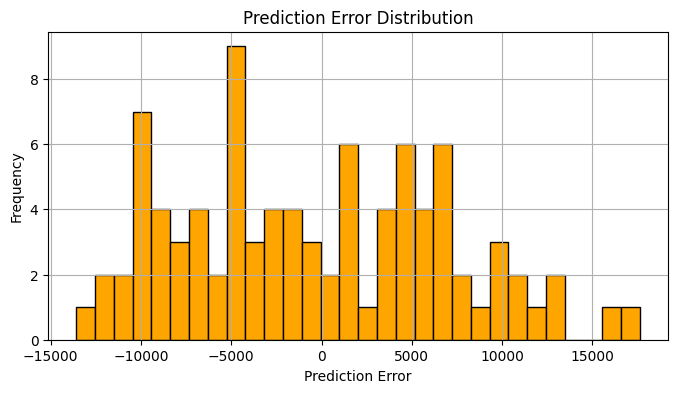

In [21]:
# ---------------- LOAD BEST MODEL ----------------
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# ---------------- EVALUATE ON TEST SET ----------------
preds_all, targets_all = [], []
with torch.no_grad():
    for imgs, tabs, targets in test_loader:
        imgs, tabs = imgs.to(DEVICE), tabs.to(DEVICE)
        preds = model(imgs, tabs).cpu().numpy().squeeze()
        preds_all.extend(preds)
        targets_all.extend(targets.numpy().squeeze())

# Inverse transform scaled prices
preds_unscaled = price_scaler.inverse_transform(np.array(preds_all).reshape(-1, 1)).squeeze()
targets_unscaled = price_scaler.inverse_transform(np.array(targets_all).reshape(-1, 1)).squeeze()

# Compute metrics
mae = mean_absolute_error(targets_unscaled, preds_unscaled)
rmse = np.sqrt(mean_squared_error(targets_unscaled, preds_unscaled))
print(f"✅ Final Test MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# ---------------- VISUALIZATIONS ----------------
import matplotlib.pyplot as plt
# 3️⃣ Error Distribution
errors = preds_unscaled - targets_unscaled
plt.figure(figsize=(8,4))
plt.hist(errors, bins=30, color='orange', edgecolor='black')
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [18]:
# ---------------- EVALUATION ----------------
model.eval()
preds_all, targets_all = [], []
with torch.no_grad():
    for imgs, tabs, targets in test_loader:
        imgs, tabs = imgs.to(DEVICE), tabs.to(DEVICE)
        preds = model(imgs, tabs).cpu().numpy().squeeze()
        preds_all.extend(preds)
        targets_all.extend(targets.numpy().squeeze())

# Inverse transform
preds_original = price_scaler.inverse_transform(np.array(preds_all).reshape(-1,1))
targets_original = price_scaler.inverse_transform(np.array(targets_all).reshape(-1,1))

mae = mean_absolute_error(targets_original, preds_original)
rmse = np.sqrt(mean_squared_error(targets_original, preds_original))
print(f"✅ Test MAE: {mae:.2f}, RMSE: {rmse:.2f}")



✅ Test MAE: 6529.99, RMSE: 7842.82


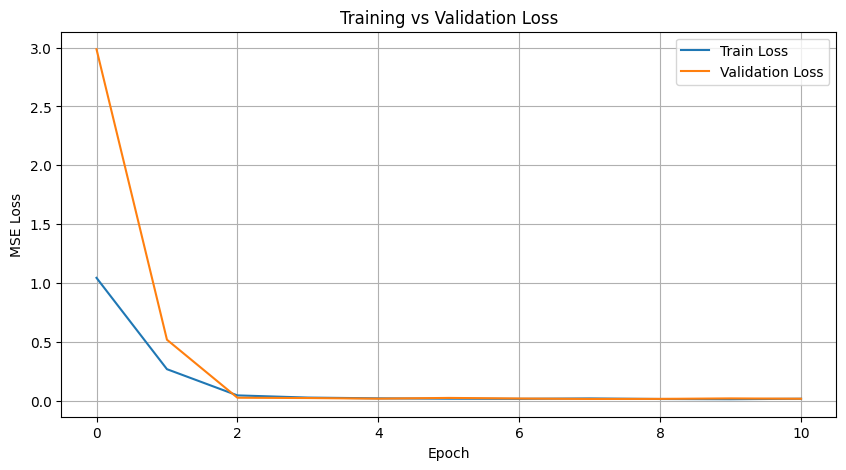

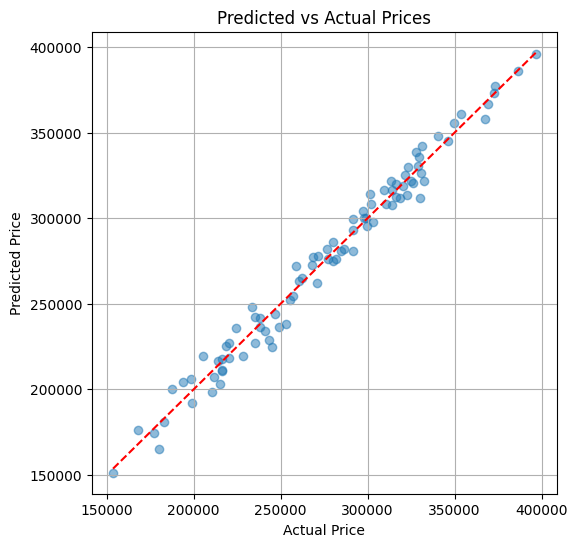

In [19]:
# ---------------- GRAPHS ----------------
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(targets_original, preds_original, alpha=0.5)
plt.plot([targets_original.min(), targets_original.max()],
         [targets_original.min(), targets_original.max()],
         'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.grid(True)
plt.show()
